<a href="https://colab.research.google.com/github/theDreamer911/dailyChallenges/blob/master/ResNet_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

# Load the CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


Samples from the loaded CIFAR dataset can be displayed using this code

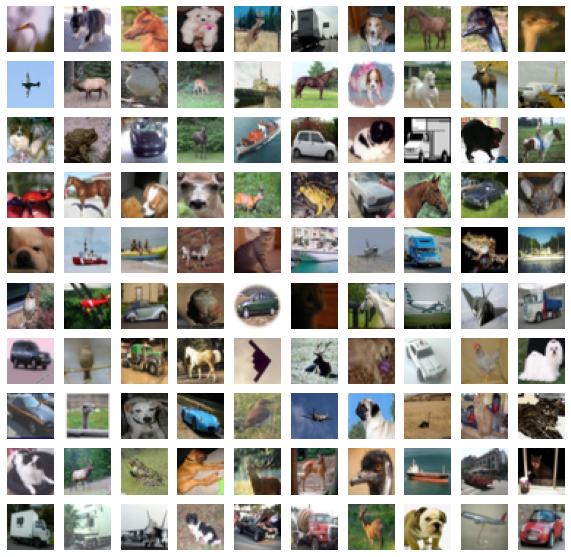

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle

ROWS = 10

x = x_train.astype('uint8')

fig, axes1 = plt.subplots(ROWS, ROWS, figsize=(10, 10))
for j in range(ROWS):
  for k in range(ROWS):
    i = np.random.choice(range(len(x)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(x[i:i+1][0])

we willconstruct a ResNet and train it on the CIFAR-10 dataset

In [3]:
# Training parameters
BATCH_SIZE = 32 # Orig paper trained all network with batch_size = 128
EPOCH = 200
USE_AUGMENTATION = True
NUM_CLASSES = np.unique(y_train).shape[0]
COLORS = x_train.shape[3]

# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True

# Model Version
# Orig paper, version: 1, improved resnet version: 2
VERSION = 1

# Computed depth from supplied model parameter n
if VERSION == 1:
  DEPTH = COLORS * 6 + 2
elif VERSION == 2:
  DEPTH = COLORS * 9 + 2

Implement learning rate decay schedule

In [4]:
def lr_schedule(epoch):
  """Learning Rate Schedule
  
  Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
  Called atuomatically every epoch as part of callbacks during traininggggg

  # Arguments
    epoch (int): number of epochs

  # Returns
    lr (float32): learning rate
  """
  lr = le-3
  if epoch > 180:
    lr *= 0.5e-3
  elif epoch > 160:
    lr *= le-3
  elif epoch > 120:
    lr *= le-2
  elif epoch > 80:
    lr *= le-1
  print('Learning rate: ', lr)
  return lr

Implement ResNet block. This include two Covolutional layer with a skip connection

In [5]:
def resnet_layer(inputs,
                 num_filters=16, 
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  """2D Convolutional-Batch Normalization-Activation stack builder

  # Arguments 
    inputs (tensor): input tensor from input image or previous layer
    num_filters (int): Conv2D number of filters
    kernel_size(int): Conv2D square kernel dimensions
    strides (int): Conv2D square stride dimensions
    activation (string): activation name
    batch_normalization (bool): whether to include batch normalization
    conv_first (bool): conv-b-activation (True) or 
      bn-activation-conv (False)

  # Returns
      x (tensor): tensor as input to the next layer
  """
  conv = Conv2D(num_filters,
                kernel_size = kernel_size,
                strides = strides,
                padding = 'same',
                kernel_initializer = 'he_normal',
                kernel_regularizer = 12(le-4))
  
  x = inputs
  if conv_first:
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  else:
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
    x = conv(x)
  return x

## ResNet V1

In [11]:
def resnet_v1(input_shape, depth, num_classes=10):
  if (depth - 2) % 6 != 0:
    raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
  # Start model definition
  num_filters = 16
  num_res_blocks = int((depth - 2) / 6)

  inputs = Input(shape=input_shape)
  x = resnet_layer(inputs=inputs)

  # Instantiate the stack of residual units
  for stack in range(3):
    for res_block in range(num_res_blocks):
      strides = 1
      if stack > 0 and res_block == 0: # first layer but not first stack
        strides = 2 # downsample
    y = resnet_layer(input = x,
                     num_filters = num_filters,
                     strides = strides)
    y = resnet_layer(input=y,
                     num_filters=num_filters,
                     activation=None)
    if stack > 0 and res_block == 0: # first layer but not first stack
      # linear projection residual shortcut connection to match
      # change dims
      x = resnet_layers(inputs = x,
                        num_filters = num_filters,
                        kernel_size = 1,
                        strides = strides,
                        activation = None,
                        batch_normalization = False)
      x = tensorflow.keras.layers.add([x, y])
      x = Activation('relu')(x)
    num_filters *= 2

  # Add classifier on top
  # V1 doesn't use BN after last shortcut connection - ReLu
  x = AveragePooling2D(pool_size = 8)(x)
  y = Flatten()(x)
  outputs = Dense(num_classes,
                  activation = 'softmax',
                  kernel_initializer = 'he_normal')(y)

  # Instantiate model
  model = Model(inputs=inputs, outputs=outputs)
  return model
